# **Import Libraries:**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
#from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.xception import Xception,preprocess_input
#from tensorflow.keras.applications.InceptionResNetV2 import InceptionResNetV2, preprocess_input
#from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB5
from tensorflow.keras.regularizers import Regularizer, L1L2, L1, L2, serialize
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# **Initialize data**

In [ ]:
train_set_path = 'path to train data set'
test_set_path = 'path to test data set'
val_set_path = 'path to validation data set'

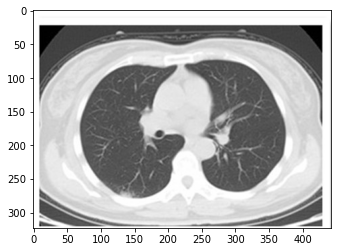

In [ ]:
plt.imshow(imread(train_set_path + '/2 covid/' + os.listdir(train_set_path + '/2 covid/')[0]), cmap='gray')

In [ ]:
target_size = (224,224)
inputs_shape = (224,224,3)
train_batch_size = 32
test_val_batch_size = 32

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255, samplewise_center=True, samplewise_std_normalization=True)

train_set_gen = data_gen.flow_from_directory(train_set_path,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              class_mode='binary',
                                              batch_size=train_batch_size,
                                              shuffle=False)

val_set_gen = data_gen.flow_from_directory(val_set_path,
                                           target_size=target_size,
                                           color_mode='rgb',
                                           class_mode='binary',
                                           batch_size=test_val_batch_size,
                                           shuffle=False)

test_set_gen = data_gen.flow_from_directory(test_set_path,
                                           target_size=target_size,
                                           color_mode='rgb',
                                           class_mode='binary',
                                           batch_size=test_val_batch_size,
                                           shuffle=False)

Found 1355 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


In [ ]:
model_MobileNet_drop_maxnorm_L2 = Sequential()

model_MobileNet_drop_maxnorm_L2.add(MobileNet(include_top=False, weights='imagenet', input_shape=inputs_shape))

model_MobileNet_drop_maxnorm_L2.add(GlobalMaxPooling2D())

model_MobileNet_drop_maxnorm_L2.add(Dense(512, activation='relu', kernel_regularizer=L2(l2=0.015), kernel_constraint=MaxNorm(2)))
model_MobileNet_drop_maxnorm_L2.add(Dropout(0.5))

model_MobileNet_drop_maxnorm_L2.add(BatchNormalization())

#model_MobileNet_drop_maxnorm_L2.add(Dense(1024, activation='relu', kernel_regularizer=L2(l2=0.03), kernel_constraint=MaxNorm(2)))
#model_MobileNet_drop_maxnorm_L2.add(Dropout(0.6))

#model_MobileNet_drop_maxnorm_L2.add(BatchNormalization())

model_MobileNet_drop_maxnorm_L2.add(Dense(64, activation='relu', kernel_regularizer=L2(l2=0.01), kernel_constraint=MaxNorm(2)))
model_MobileNet_drop_maxnorm_L2.add(Dropout(0.5))

model_MobileNet_drop_maxnorm_L2.add(Dense(1, activation='sigmoid'))

model_MobileNet_drop_maxnorm_L2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
weight_path="{}_weights.MobileNetclassification.hdf5".format('model')
checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

In [ ]:
model_MobileNet_drop_maxnorm_L2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_max_pooling2d (Global (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
STEP_SIZE_TRAIN=train_set_gen.n//train_set_gen.batch_size
STEP_SIZE_VALID=val_set_gen.n//val_set_gen.batch_size
STEP_SIZE_TEST=test_set_gen.n//test_set_gen.batch_size


result = model_MobileNet_drop_maxnorm_L2.fit(train_set_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_set_gen, validation_steps=STEP_SIZE_VALID, callbacks=[checkpoint], epochs=50)

In [ ]:
result = model_MobileNet_drop_maxnorm_L2.fit(train_set_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_set_gen, validation_steps=STEP_SIZE_VALID, callbacks=[checkpoint], epochs=50)

# **Evaluation**

**load the model which was trained and saved:**

In [ ]:
model_MobileNet_drop_maxnorm_L2.load_weights(weight_path)
model_MobileNet_drop_maxnorm_L2.save('model_MobileNet_Classification.h5')

**Test set evaluation:**

In [ ]:
model_MobileNet_drop_maxnorm_L2.evaluate_generator(test_set_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.7329394817352295, 0.8681318759918213]

**validation set evaluation:**

In [ ]:
model_MobileNet_drop_maxnorm_L2.evaluate_generator(val_set_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.7935196757316589, 0.8888888955116272]

**Train set evaluation:**

In [ ]:
model_MobileNet_drop_maxnorm_L2.evaluate_generator(train_set_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.6209328770637512, 0.9335793256759644]